Domain Basics
=============
In this file, we will explain the usage of the domain classes. 
Every domain is a child of the main class *Domain* and implements the following
methods and properties:

- **__contains__**: to check if a point lays inside this domain
- **volume**, **set_volume**: to compute or set the volume of the domain
- **bounding_box**: to get a bounding box of the given domain
- **boundary**: returns the boundary of the domain, this object itself is a domain and 
                implements the same methods. The boundary also knows the normal 
                vectors. But a boundary itself has **no** boundary!

For explicit documentation of each method and all implemented domains, 
see the docs. Some pre implemented domains are: *Point, Interval, Parallelogram, Circle...*

Here we focus now on the creation of different domains.
To create a domain, we need a space to which the domain belongs. 
The definition of spaces were part of the previous tutorial.

To create the interval [0, 5]:

In [1]:
# This is only valid when the package is not installed
import sys
sys.path.append('/home/hell/Desktop/repos/DeepINN/')

import DeepINN as dp

Using default backend: PyTorch
Using Pytorch:  2.0.1+cu117


In [2]:
T = dp.spaces.R1('t') # we need a one dimensional space
I = dp.domains.Interval(T, 0, 5)

To create the unit square or circle:

In [3]:
X = dp.spaces.R2('x') # we need a two dimensional space
R = dp.domains.Parallelogram(X, [0, 0], [1, 0], [0, 1])
C = dp.domains.Circle(X, [0, 0], 1)
# boundaries:
R_bound = R.boundary
C_bound = C.boundary

Now it would be nice to look at the domains directly. 

/home/hell/Desktop/repos/DeepINN/.venv/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/hell/Desktop/repos/DeepINN/DeepINN/geometry/domains/domain2D/parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)


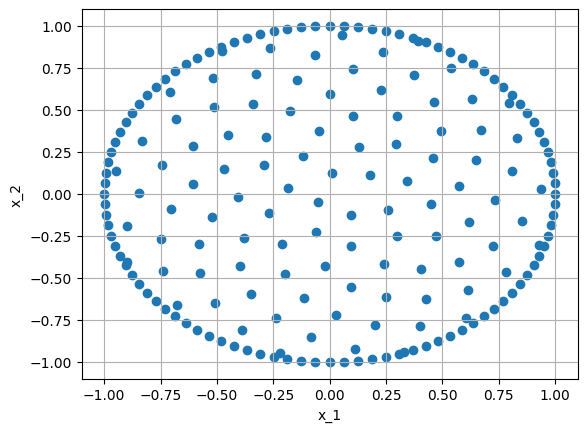

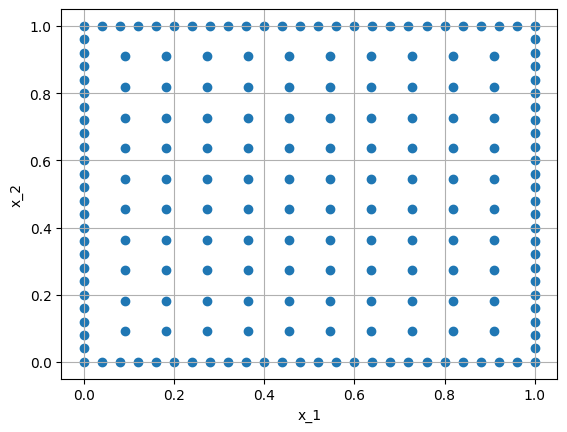

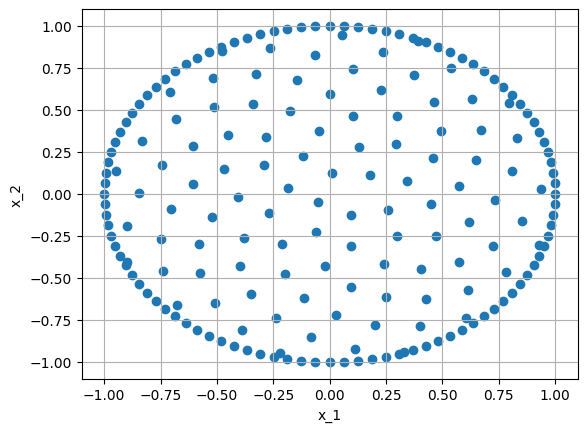

In [5]:
R_sampler = dp.samplers.GridSampler(R, n_points=100) + dp.samplers.GridSampler(R.boundary, n_points=100)
C_sampler = dp.samplers.GridSampler(C, n_points=100) + dp.samplers.GridSampler(C.boundary, n_points=100)

dp.utils.scatter(X, R_sampler)
dp.utils.scatter(X, C_sampler)

The definition of other basic domains, follow the same way.

Domain Operations
-----------------

Until now we only created simple geometries. For complex domains
 the following operations are implemented:

- **Union** $A \cup B$, implemented with: **'+'**
- **Intersection** $A \cap B$, implemented with: **'&'**
- **Cut** $A \setminus B$, implemented with: **'-'**
- **Cartesian product** $A \times B$, implemented with: **'$\cdot$'**

The only important aspect is that for union, intersection and cut the 
domains have to belong to the same space. The returning object is a child of
 *Domains* and implements all previously mentioned methods. 
 The operation can be used for an arbitrary number of times, 
 but for complex domains, the creation of training points will possibly become costly and slow. 

In [6]:
union_domain = R + C
intersection_domain = R & C
cut_domain = R - C

The boundary can be again called with **.boundary**. Since the operation can create 
complex domains the voluem can not always be computed. If a exact value is needed, 
one has to set it over the **set_volume** methode.

Again we can have a look at the corresponding geometries: 

/home/hell/Desktop/repos/DeepINN/DeepINN/geometry/domains/domainoperations/union.py:30: UserWarning: Exact volume of this union is not known, will use the
                             estimate: volume = domain_a.volume + domain_b.volume.
                             If you need the exact volume for sampling,
                             use domain.set_volume()
  warnings.warn("""Exact volume of this union is not known, will use the
/home/hell/Desktop/repos/DeepINN/DeepINN/geometry/domains/domainoperations/sampler_helper.py:50: UserWarning: Will sample random points in the created domain operation, with
                     a for loop over all input parameters, in total: 1
                     This may slow down the training.
  warnings.warn(f"""Will sample random points in the created domain operation, with
/home/hell/Desktop/repos/DeepINN/DeepINN/geometry/domains/domainoperations/sampler_helper.py:163: UserWarning: Will sample random points in the created domain operation, with
      

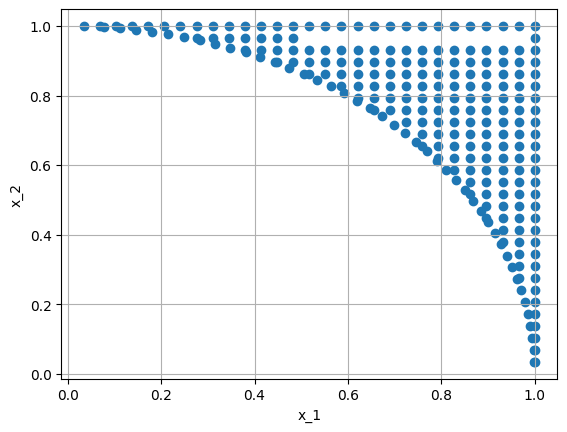

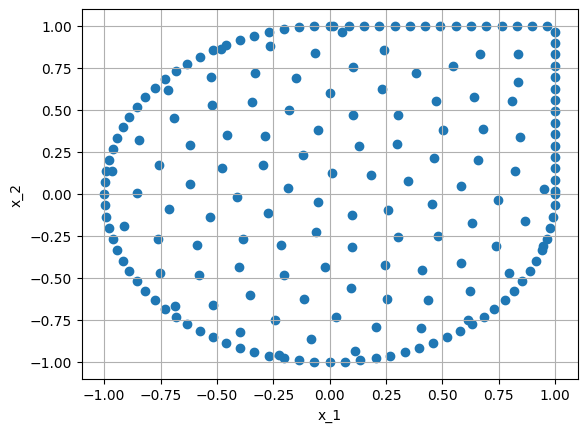

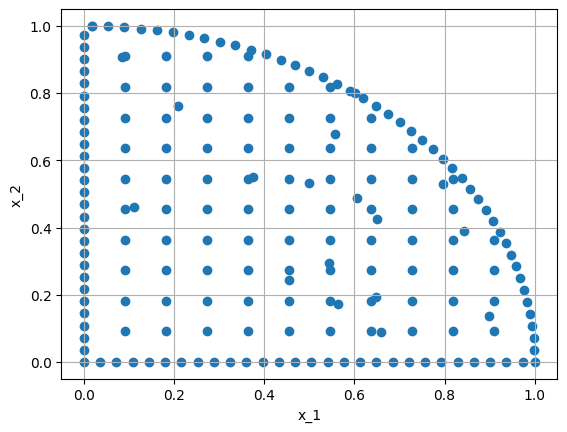

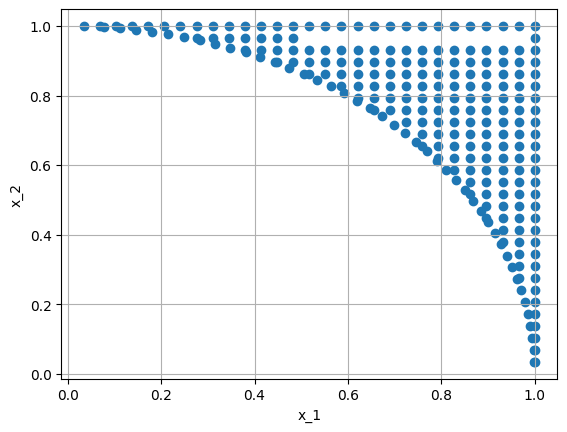

In [7]:
union_sampler = dp.samplers.GridSampler(union_domain, n_points=100) \
                 + dp.samplers.GridSampler(union_domain.boundary, n_points=100)
inter_sampler = dp.samplers.GridSampler(intersection_domain, n_points=100) \
                 + dp.samplers.GridSampler(intersection_domain.boundary, n_points=100)
cut_sampler = dp.samplers.GridSampler(cut_domain, n_points=142) \
               + dp.samplers.GridSampler(cut_domain.boundary, n_points=100)

dp.utils.scatter(X, union_sampler)
dp.utils.scatter(X, inter_sampler)
dp.utils.scatter(X, cut_sampler)

For the product, we create the Cartesian product of an interval and circle to get a cylinder:

In [8]:
cylinder = C * I

The product domain will lay in the product of the spaces.
For example, the above cylinder lays now in the space $X \cdot T$

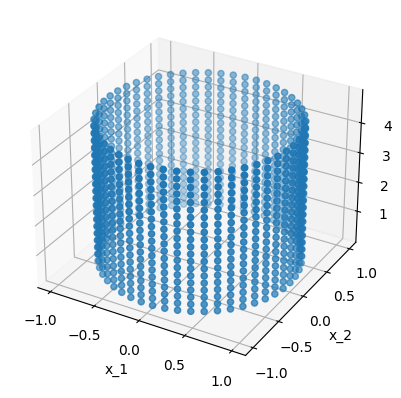

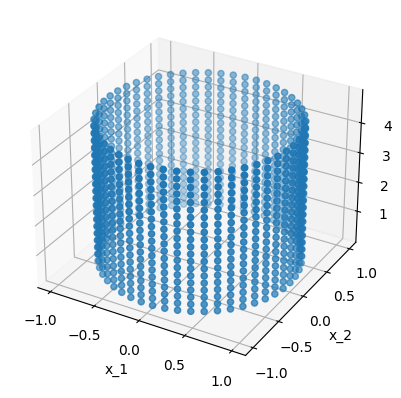

In [9]:
product_sampler = dp.samplers.GridSampler(C.boundary, n_points=50) * dp.samplers.GridSampler(I, n_points=20)
dp.utils.scatter(X*T, product_sampler)

Changing Domains
----------------
The last aspect, is the possibility of variable domains. E.g. a domain that grows in time or 
a rotating circle. To this end, all parameters that to define a domain can also be function.
For example, the radius of the circle or the origin of a parallelogram.

Right now, a domain can only depend on the variables of another domain. So a domain that should
change with the trained solution is not possible, for now.

The creation of the domains stays the same, one has to only replace the desired parameters.

In [10]:
C = dp.domains.Circle(X, [0, 0], lambda t: t/5)

These domains can be used like all the other domains to create a product domain or apply an operation.

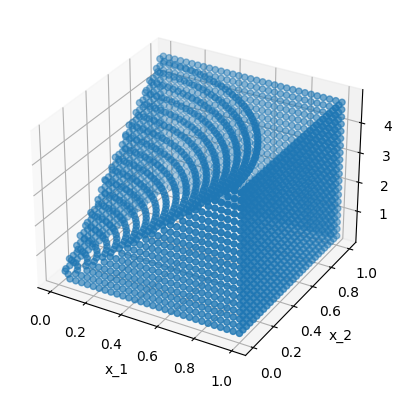

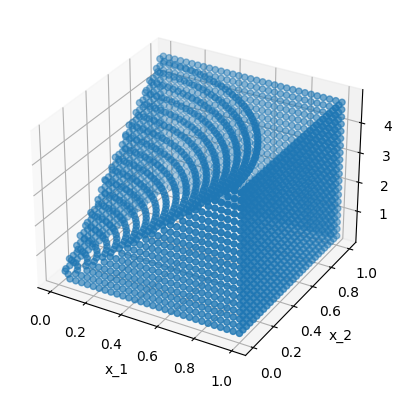

In [11]:
new_domain = R - C
product_sampler = dp.samplers.GridSampler(new_domain.boundary, density=30) \
                    * dp.samplers.GridSampler(I, n_points=20)
dp.utils.scatter(X*T, product_sampler)